# Pump it Up: Data Mining the Water Table

#### Analysed By :  Osafa Karim (osafa.karim@gmail.com)
#### Analysed On : 4th July 2019
#### Analysed for : Axiata Analytics - Employment Test

##### Python kernel Used

In [1]:
# kernel used
from platform import python_version
print('The version of ',python_version())

The version of  3.6.8


In [2]:
# importing the data-analysis and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
%matplotlib inline

import os
import requests

import re 
import geopy.distance

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

##### Download the data set for analyses from the url as is in the 
##### https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/

In [3]:
def download_data(url, file_name):
    '''
    input : 
       1. url - the url from where the file has to be downloaded
       2. file_name - the name with with the corresponding file has to be created 
    '''
    if file_name not in os.listdir():
        t0 = datetime.now()
        response = requests.get(url)
        with open(os.path.join(os.getcwd(), file_name), 'wb') as f:
            f.write(response.content)
        
        print('****** File ', file_name,', of size :',os.path.getsize(file_name)/1000000 ,' MB sucessfully downloaded in ',
             str((datetime.now()- t0).seconds),' seconds !!!!.')
    else:
        print('****** File with name ',file_name,' already exists. Please verify.')
        


In [4]:
# training-set values
url = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
file_name = 'raw_train_feature_vectors.csv'
download_data(url, file_name)

****** File with name  raw_train_feature_vectors.csv  already exists. Please verify.


In [5]:
# training-set labels
url = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
file_name = 'raw_train_target_vectors.csv'
download_data(url, file_name)

****** File with name  raw_train_target_vectors.csv  already exists. Please verify.


In [6]:
# testing-set values
url = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'
file_name = 'raw_test_feature_vectors.csv'
download_data(url, file_name)

****** File with name  raw_test_feature_vectors.csv  already exists. Please verify.


#### Data Description

In [7]:
# train data-set 

train_data = pd.read_csv('raw_train_feature_vectors.csv')

In [8]:
print('There {} features and {} data-points in train-data set.'.format(train_data.shape[1],train_data.shape[0]))

There 40 features and 59400 data-points in train-data set.


In [9]:
# get the data-types of the features
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [10]:
# Casting the data types of date fileds to datetime dtype
train_data['date_recorded'] = pd.to_datetime(train_data['date_recorded'])
#train_data['construction_year'] = pd.to_datetime(train_data['construction_year'])

##### Check for missing data 


In [11]:
#train_data.isna().sum()
for a in train_data.columns[train_data.isna().any()].tolist():
    print(a ,' has ',train_data[train_data[a].isna()].shape[0],' missing values')

funder  has  3635  missing values
installer  has  3655  missing values
subvillage  has  371  missing values
public_meeting  has  3334  missing values
scheme_management  has  3877  missing values
scheme_name  has  28166  missing values
permit  has  3056  missing values


In [12]:
# Count of types of features
categorical = len(train_data.select_dtypes(include='object').columns)
integ = len(train_data.select_dtypes(include='int64').columns)
float_num = len(train_data.select_dtypes(include='float64').columns)
date_time = len(train_data.select_dtypes(include='datetime64[ns]').columns)


In [13]:
categorical, integ, float_num, date_time

(29, 7, 3, 1)

In [14]:
dty_list =[]

for a, b in zip([categorical, integ, float_num, date_time],['categorical', 'integ', 'float_num', 'date_time']):
    for _ in range(a):
            dty_list.append(b)
    

Text(0.5, 1.0, ' Comparison of the fetaures by dtypes')

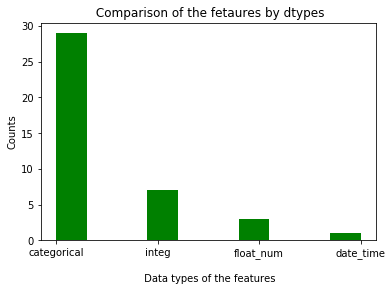

In [15]:
plt.hist(dty_list, color = 'green')
plt.xlabel('\n Data types of the features')
plt.ylabel('Counts')
plt.title(' Comparison of the fetaures by dtypes')

In [16]:
# Start dissecting the categorical features 
[ col for col in train_data.columns if train_data[col].dtypes == 'object']

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

###### Let's visualize and analyze each of the categorical features for more insights .
###### 1. Funder -  Let's visualize the top 30 Organizations who have funded the water-resources

In [17]:
fund_30 = pd.DataFrame(train_data['funder'].value_counts().head(30))

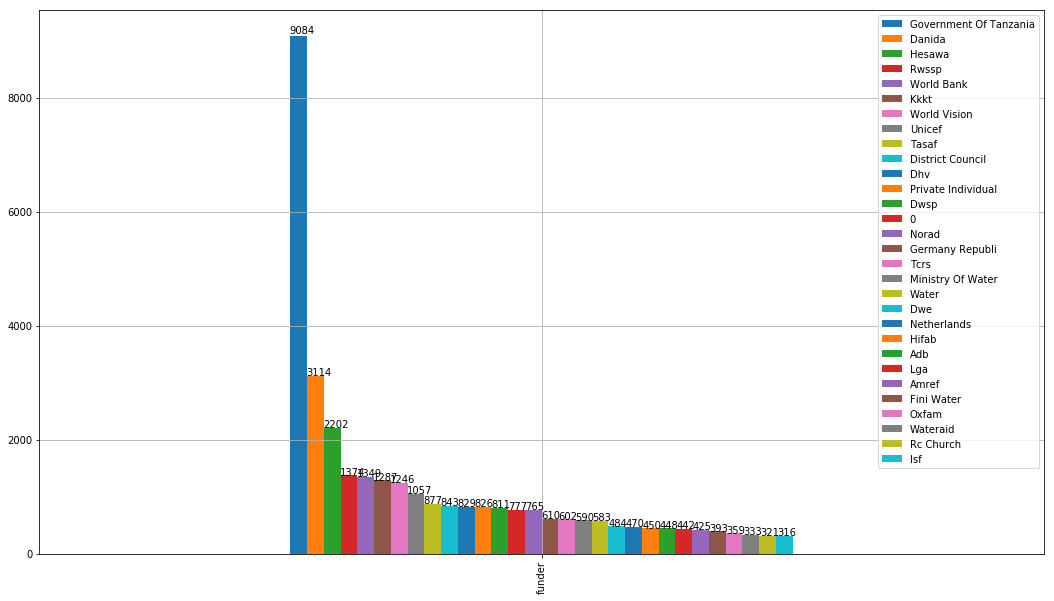

In [18]:
ax = fund_30.T.plot(kind='bar', figsize = (18, 10) , grid = True )
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### 2. Installer  -  Let's visualize top 30 installers 

In [19]:
install_30 = pd.DataFrame(train_data['installer'].value_counts().head(30))

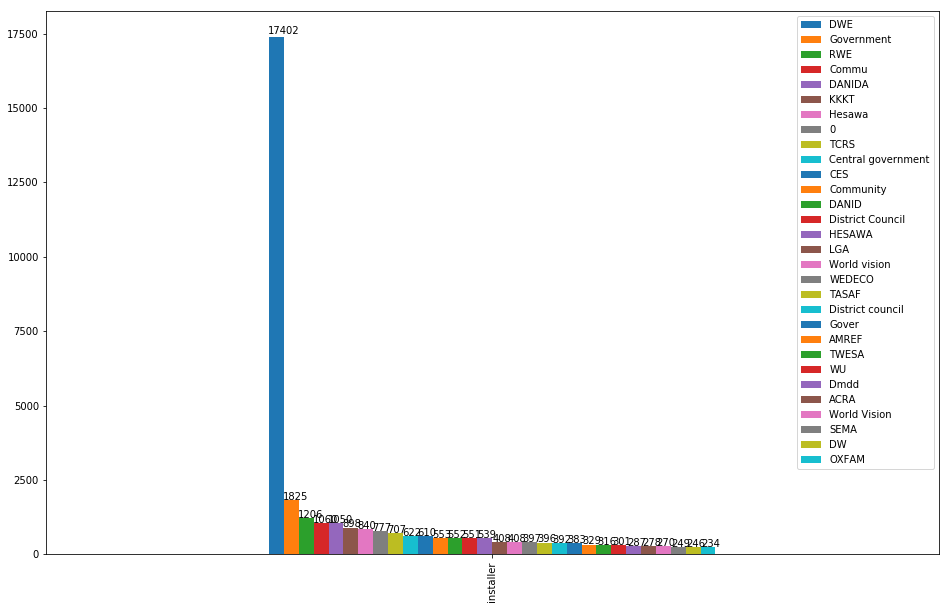

In [20]:
ax = install_30.T.plot(kind = 'bar' , figsize = (16, 10))
for p in ax.patches:
     ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

#####  *** Insight -1  ; funders and installers may or may not be same.

##### 3. wpt_name  - The name of the water points in the locality

In [21]:
wpt_30  = pd.DataFrame(train_data['wpt_name'].value_counts().head(30))

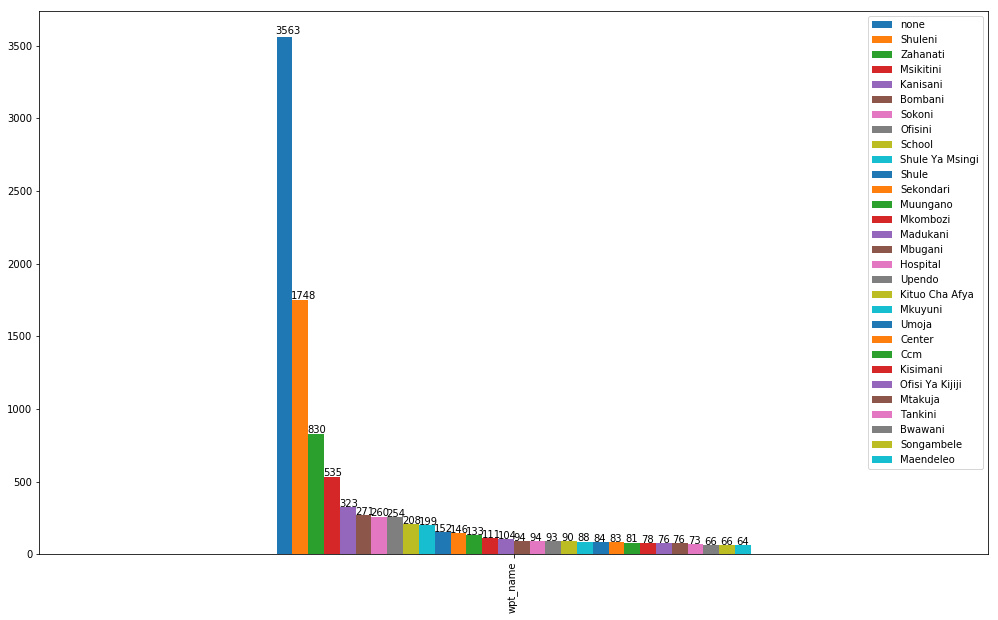

In [22]:
ax = wpt_30.T.plot(kind = 'bar' , figsize = (17, 10))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### *** Insight -2  ; A good number of locations doesn't have water_points

##### 4. basin -  Geographical Water Basin

In [23]:
len(train_data['basin'].unique())

9

In [24]:
# checking if there are missing values for basin
train_data['basin'].isna().sum()

0

#####  *** Insight -3 .  There are 9 basins from where all the waters are supplied.

In [25]:
# Let's visualize , how basins compare in terms of supplying the water
basin_df = pd.DataFrame(train_data['basin'].value_counts())

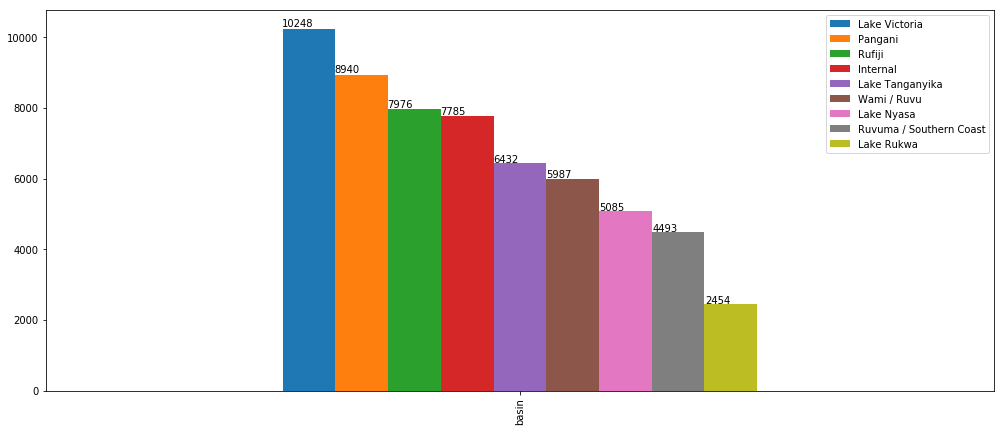

In [26]:
ax = basin_df.T.plot(kind = 'bar', figsize=(17,7))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### 5. subvillage -  Geographical Region

In [27]:
#train_data['subvillage'].value_counts()

In [28]:
train_data['subvillage'].isna().sum()

371

In [29]:
len(train_data['subvillage'].unique())

19288

##### At this point there is an intuition that all the features related geographical distance has a bearance in terms of proximity to main-water-bidies(basins) , which are the source of supplies for these water-points.

'Lake Victoria' = Latitude: -1° 00' 0.00" S
Longitude: 33° 00' 0.00" E

'Pangani' = Latitude: -5° 25' 30.94" S
Longitude: 38° 58' 29.03" E

'Rufiji' = Latitude: -8° 00' 0.00" S
Longitude: 39° 19' 60.00" E

'Internal'(same as ruvu) = Latitude: -6° 48' 17.99" S
Longitude: 38° 41' 59.99" E

'Lake Tanganyika' = 6.2556° S, 29.5108° E

'Wami' - Latitude: -6° 07' 60.00" S
Longitude: 38° 48' 59.99" E

'Lake Nyasa' = 11.6701° S, 34.6857° E

'Ruvuma' = 10.6879° S, 36.2631° E

'Lake Rukwa' = 8.0167° S, 32.2654° E

In [30]:
train_data['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

##### 6. region  - Geographic location (coded)

In [31]:
train_data['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [32]:
region_data = pd.DataFrame(train_data['region'].value_counts())

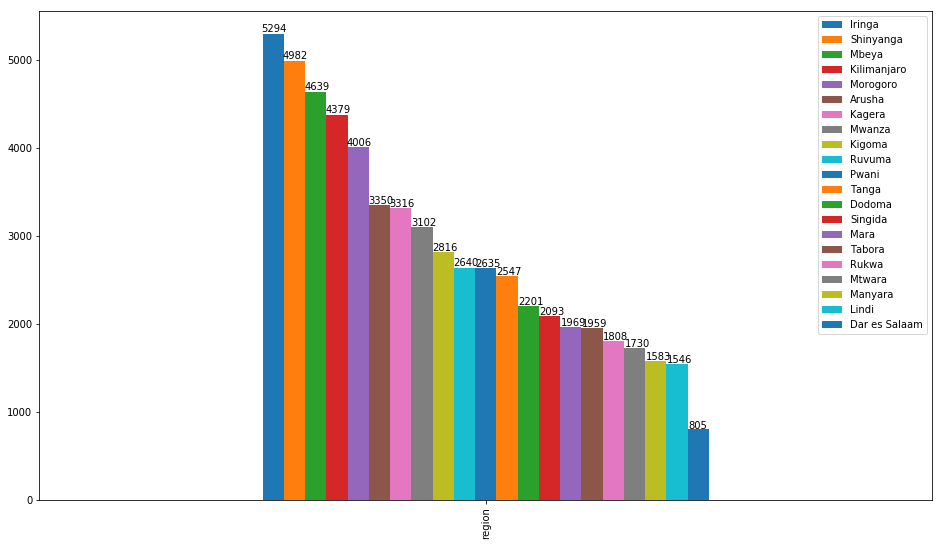

In [33]:
ax = region_data.T.plot(kind = 'bar', figsize= (16,9))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### 7.lga - Geographic location

In [34]:
print('Number of LGA in the dataset : ',len(train_data['lga'].unique()),
      ' and number of missing entries is ',train_data['lga'].isna().sum())

Number of LGA in the dataset :  125  and number of missing entries is  0


In [35]:
print('Number of regions in the dataset : ',len(train_data['region'].unique()),
     ' and number of missing entries is ',train_data['region'].isna().sum())

Number of regions in the dataset :  21  and number of missing entries is  0


###### *** Insight 4 - lga and region might be redundant informations for predictive modelling, for analysis and administrative view of which locations and their corresponding sub-locations has more issues

In [36]:
agg_reg_lga = train_data[['region','lga']].groupby('region').count()

Text(0, 0.5, ' Count of lga ')

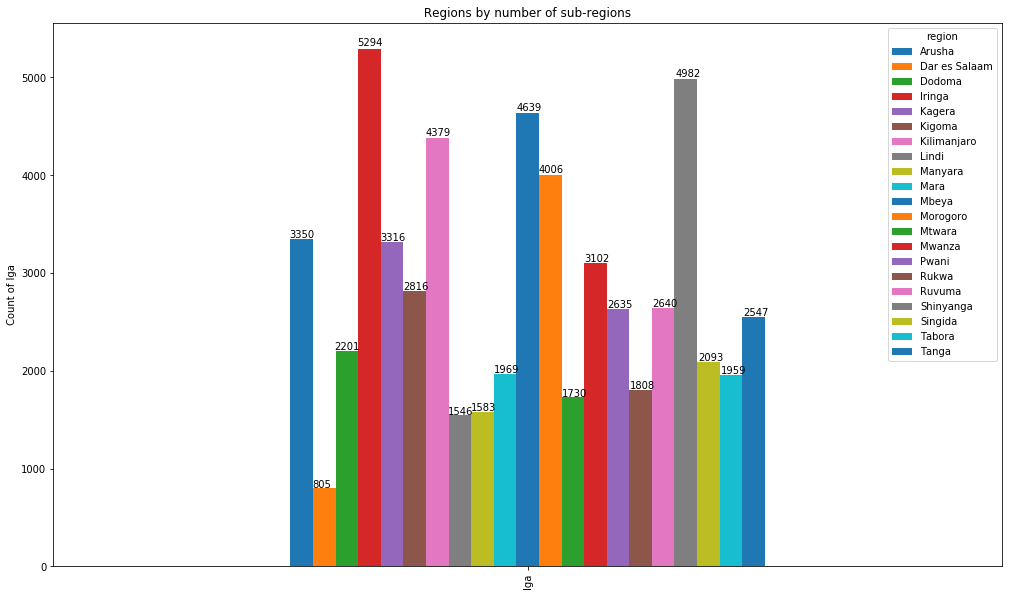

In [37]:
ax = agg_reg_lga.T.plot(kind = 'bar', figsize=(17, 10))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title(' Regions by number of sub-regions ')
plt.ylabel(' Count of lga ')

##### 8. ward - Geographic location 

In [38]:
print('Number of wards in the dataset : ',len(train_data['ward'].unique()),
     ' and number of missing entries is ',train_data['ward'].isna().sum())

Number of wards in the dataset :  2092  and number of missing entries is  0


##### **** Insight - 5 So "ward" is the sub-category of the "lga" which is sub-category to "region"

In [39]:
location_df = train_data[['region','lga','ward']].groupby(['region','lga']).count()

In [40]:
location_df

ward
region        lga                   
Arusha        Arusha Rural      1252
              Arusha Urban        63
              Karatu             326
              Longido            310
              Meru              1009
              Monduli            189
              Ngorongoro         201
Dar es Salaam Ilala              497
              Kinondoni           93
              Temeke             215
Dodoma        Bahi               224
              Chamwino           347
              Dodoma Urban       358
              Kondoa             523
              Kongwa             361
              Mpwapwa            388
Iringa        Iringa Rural       728
              Kilolo             349
              Ludewa             564
              Makete             630
              Mufindi            520
              Njombe            2503
Kagera        Biharamulo         403
              Bukoba Rural       487
              Bukoba Urban        88
              Chato              236
              Karagwe            771
              Misenyi            260
              Muleba             402
              Ngara              669
Kigoma        Kasulu            1047
              Kibondo            874
              Kigoma Rural       824
              Kigoma Urban        71
Kilimanjaro   Hai                625
              Moshi Rural       1251
              Moshi Urban         79
              Mwanga             519
              Rombo              594
              Same               877
              Siha               434
Lindi         Kilwa              392
              Lindi Rural        388
              Lindi Urban         21
              Liwale             154
              Nachingwea         300
              Ruangwa            291
Manyara       Babati             511
              Hanang             274
              Kiteto             193
              Mbulu              297
              Simanjiro          308
Mara          Bunda              438
              Musoma Rural       396
              Rorya              210
              Serengeti          716
              Tarime             209
Mbeya         Chunya             298
              Ileje              231
              Kyela              859
              Mbarali            626
              Mbeya Rural        485
              Mbozi             1034
              Rungwe            1106
Morogoro      Kilombero          959
              Kilosa            1094
              Morogoro Rural     521
              Morogoro Urban      96
              Mvomero            671
              Ulanga             665
Mtwara        Masasi             528
              Mtwara Rural       423
              Mtwara Urban       124
              Nanyumbu           158
              Newala             231
              Tandahimba         266
Mwanza        Geita              488
              Ilemela            142
              Kwimba             627
              Magu               824
              Missungwi          348
              Nyamagana            1
              Sengerema          331
              Ukerewe            341
Pwani         Bagamoyo           997
              Kibaha             269
              Kisarawe           223
              Mafia              132
              Mkuranga           560
              Rufiji             454
Rukwa         Mpanda             679
              Nkasi              428
              Sumbawanga Rural   521
              Sumbawanga Urban   180
Ruvuma        Mbinga             750
              Namtumbo           694
              Songea Rural       693
              Songea Urban        80
              Tunduru            423
Shinyanga     Bariadi           1177
              Bukombe            514
              Kahama             836
              Kishapu            399
              Maswa              809
              Meatu              468
              Shinyanga Rural    588
              Shinyanga Urban    191

#### 9. public_meeting - True/False

In [41]:
train_data['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

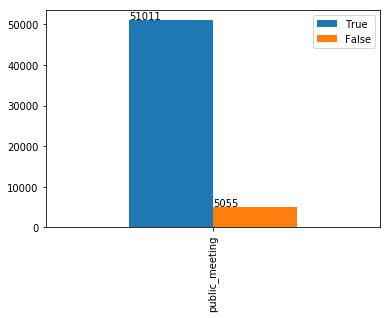

In [42]:
ax = pd.DataFrame(train_data['public_meeting'].value_counts()).T.plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))

##### 10. recorded_by - Group entering this row of data

In [43]:
train_data['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

#### **** All the data was recorded by "GeoData Consultants Ltd"  

#### This info may be left out while model creation as there isn't anything a recorder can do to make prediction of the pumps condition.

##### 11. scheme_management - Who operates the waterpoint

In [44]:
scheme_mgmt = pd.DataFrame(train_data['scheme_management'].value_counts())

Text(0.5, 0, ' Scheme Management')

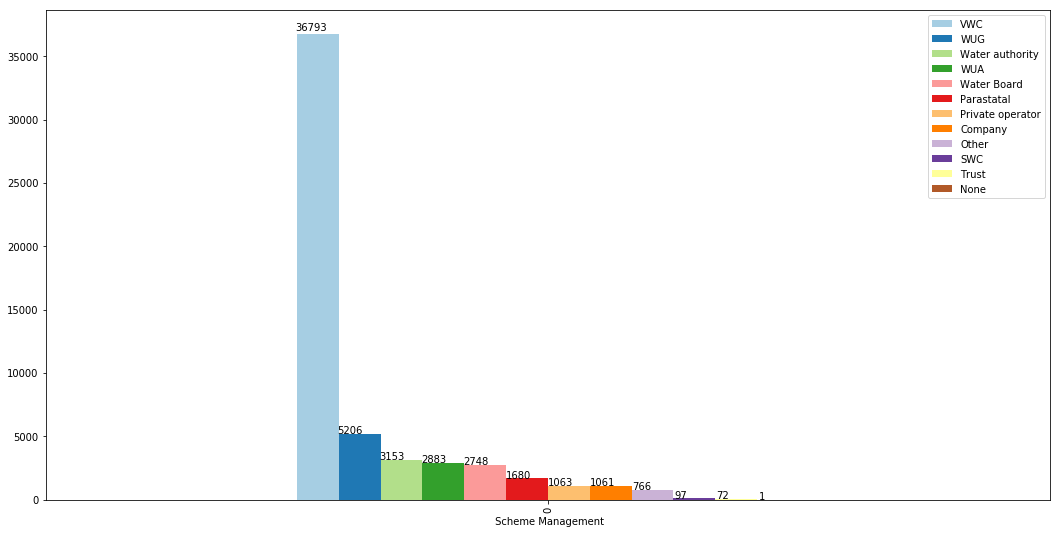

In [45]:
ax = scheme_mgmt.T.plot(kind = 'bar', figsize=(18,9) , colormap = 'Paired', use_index= False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Scheme Management')

In [46]:
train_data['scheme_management'].isna().sum()

3877

#### 12. scheme_name - Who operates the waterpoint

##### scheme_name is name of the scheme manged by a particular scheme_management . It would be interesting to see who manages how many . Depending on who manges , model can eschew the pattern of mangement related to pump condition.    
##### Hence, the above figure .  The scheme_management is useful and scheme_name becomes redundant info.

#### 13. permit - If the waterpoint is permitted

In [47]:
permit_df = pd.DataFrame(train_data['permit'].value_counts())

Text(0.5, 0, ' Permit')

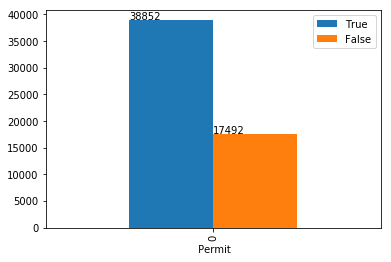

In [48]:
ax = permit_df.T.plot(kind = 'bar', use_index = False )
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Permit')

##### *** Insight 6 - A huge number of pumps , nearly a third are without permit.

#### 14. extraction_type - The kind of extraction the waterpoint uses

In [49]:
extract_df = pd.DataFrame(train_data['extraction_type'].value_counts())

Text(0.5, 0, ' Extraction Type')

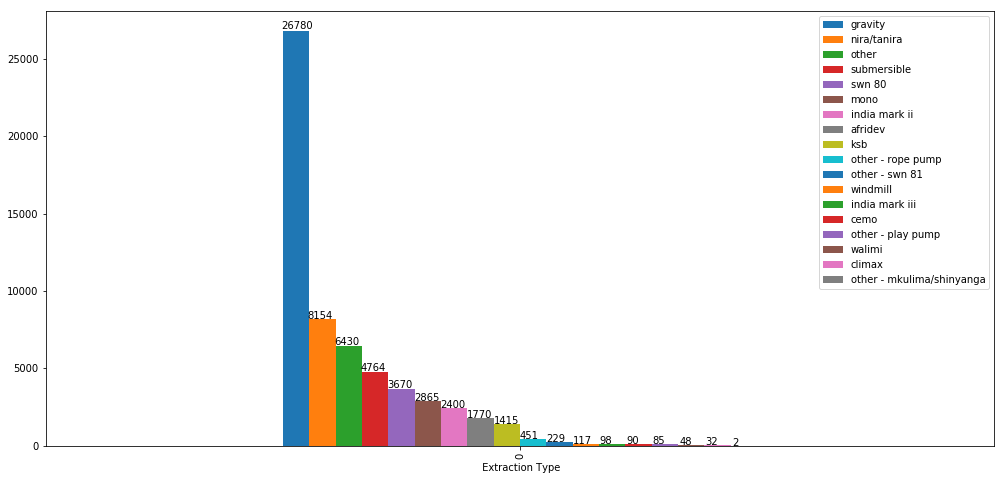

In [50]:
ax = extract_df.T.plot(kind = 'bar', figsize=(17, 8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Extraction Type')

##### *** Insight 7 - The highest , about 50 percent of the pumps use gravity as extraction_type.

#### 15. extraction_type_group - The kind of extraction the waterpoint uses

In [51]:
train_data['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [52]:
train_data['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [53]:
train_data['extraction_type_group'].isna().sum()

0

In [54]:
train_data['extraction_type'].isna().sum()

0

###### Both "extraction_type_group" and "extraction_type" are all but same , hence we can use either and drop the other for while predictive modelling.

#### 16. extraction_type_class - The kind of extraction the waterpoint uses

In [55]:
train_data['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [56]:
train_data['extraction_type_class'].isna().sum()

0

#### 17. management - How the waterpoint is managed

In [57]:
mgmt_df = pd.DataFrame(train_data['management'].value_counts())

Text(0.5, 0, ' Management')

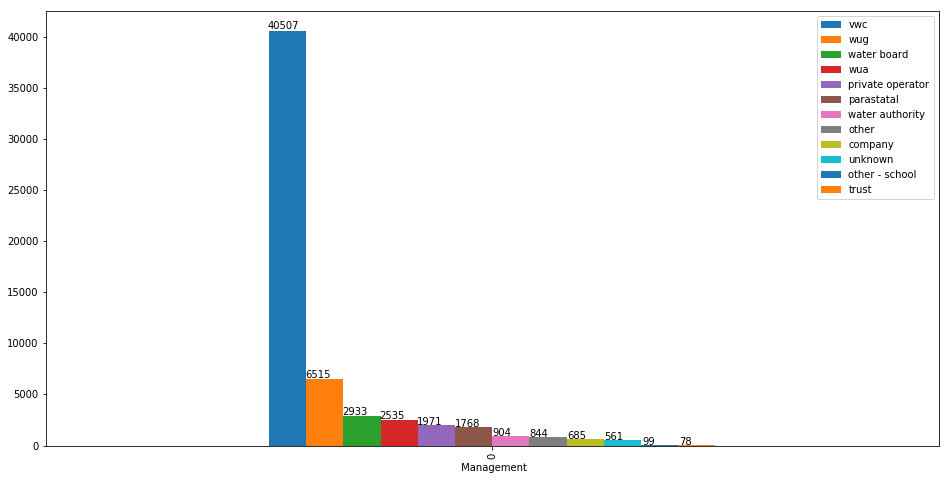

In [58]:
ax = mgmt_df.T.plot(kind = 'bar', figsize=(16,8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Management')

#### 18. management_group - How the waterpoint is managed

In [59]:
mgmt_grp_df = pd.DataFrame(train_data['management_group'].value_counts())

Text(0.5, 0, ' Management Group')

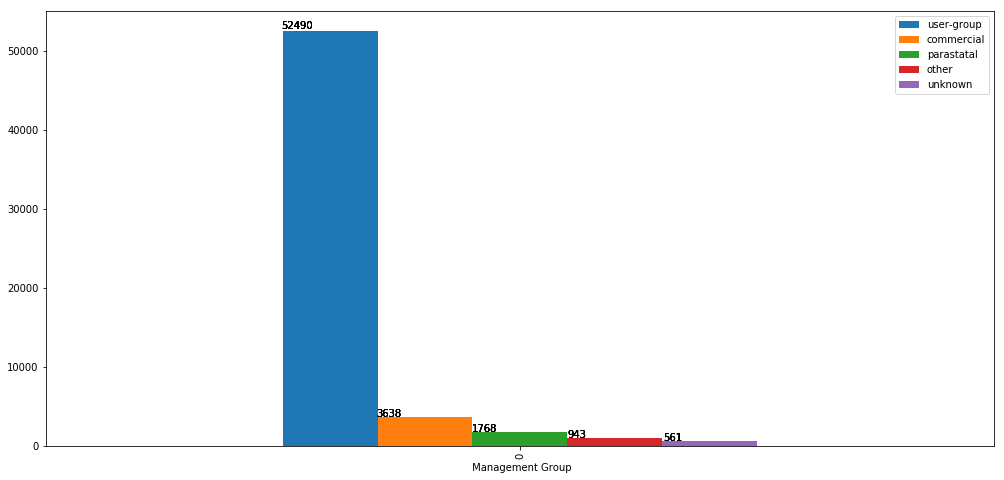

In [60]:
ax = mgmt_grp_df.T.plot(kind = 'bar', figsize=(17, 8), use_index=False)
for p in ax.patches:
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Management Group')

#### 19. payment - What the water costs

In [61]:
pay_df = pd.DataFrame(train_data['payment'].value_counts())

Text(0.5, 0, ' Payment')

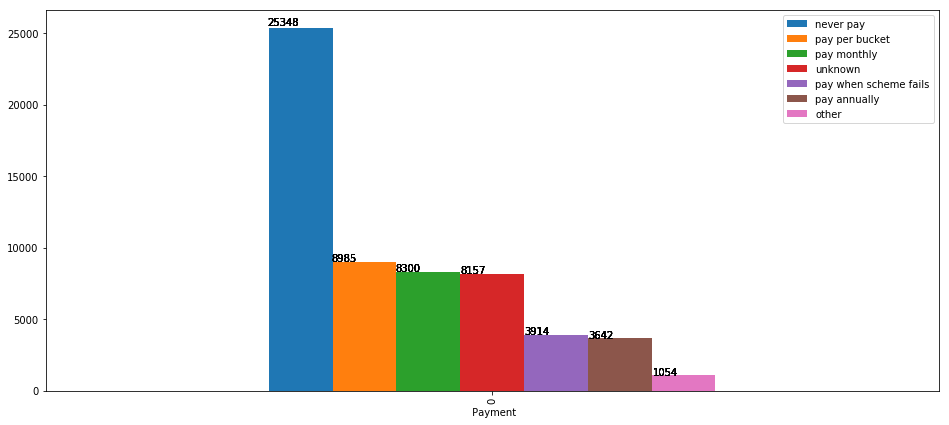

In [62]:
ax = pay_df.T.plot(kind = 'bar', figsize=(16, 7), use_index=False)
for p in ax.patches:
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Payment')

###### *** Insight 8 -  There are huge no-payments , gives the intuitions of what maintenance would have been done.

#### 20. payment_type - What the water costs

In [63]:
train_data['payment_type'].value_counts() 

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [64]:
train_data['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

#### "Payment_type" and "Payment" are duplicate , hence one has to dropped while modelling.

#### 21. water_quality - The quality of the water

In [65]:
wtr_qlt_df = pd.DataFrame(train_data['water_quality'].value_counts())

Text(0.5, 0, ' Water Quality ')

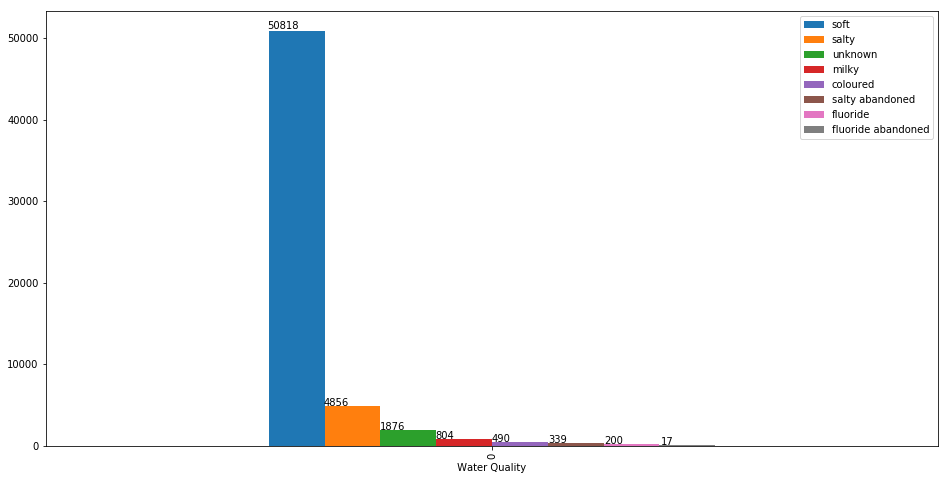

In [66]:
ax = wtr_qlt_df.T.plot(kind = 'bar', figsize=(16,8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Water Quality ')

##### *** Insight 9  - Most of the water are soft .

#### 22. quality_group - The quality of the water

In [67]:
qlt_grp_df = pd.DataFrame(train_data['quality_group'].value_counts())

Text(0.5, 0, ' Quality Group ')

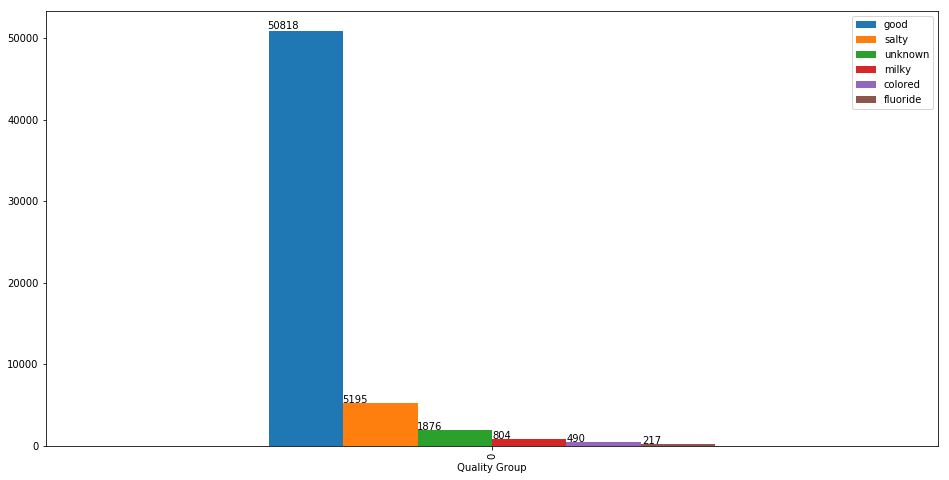

In [68]:
ax = qlt_grp_df.T.plot(kind = 'bar', figsize=(16,8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Quality Group ')

#### "water_quality" and "quality_group" apparently from the above 2 figures look same/redundant , hence one can drop either one while modelling.

#### 23. quantity - The quantity of water

In [69]:
train_data['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

#### 24. quantity_group - The quantity of water

In [70]:
train_data['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

##### "quantity" and "quantity_group" are redundant hence , one can drop either and just use one for modelling. 

#### 25. source - The source of the water

In [71]:
train_data['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

#### 26. source_type - The source of the water

In [72]:
train_data['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

##### 'Source_type' looks redundant to "source" hence , while modelling one can drop "source_type".

#### 27. source_class - The source of the water

In [73]:
src_cls_df = pd.DataFrame(train_data['source_class'].value_counts())

Text(0.5, 0, ' Source Class ')

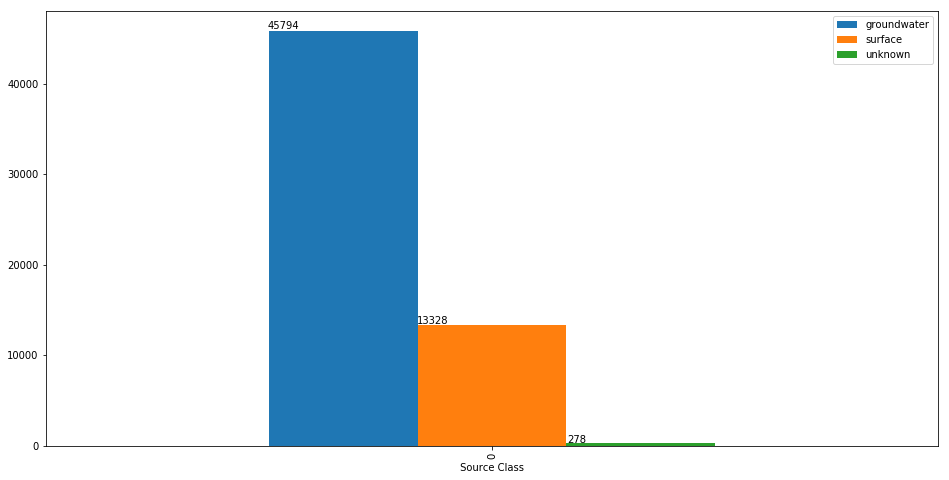

In [74]:
ax = src_cls_df.T.plot(kind = 'bar', figsize=(16,8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Source Class ')

#### 28. waterpoint_type - The kind of waterpoint

In [75]:
train_data['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

#### 29 . waterpoint_type_group - The kind of waterpoint

In [76]:
train_data['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

##### "waterpoint_type" and "waterpoint_type_group" are redundant and either one can be dropped while modelling.

#### Let's visualize and analyze each of the numerical features for more insights .

In [77]:
[col for col in train_data.columns if train_data[col].dtypes in ('int64','float64')]

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

#### 1. Id is just id , hence ignore it 

#### 2. amount_tsh - Total static head (amount water available to waterpoint)

In [78]:
tsh_df = train_data[train_data['amount_tsh']  != 0]['amount_tsh']

In [79]:
len(tsh_df)

17761

In [80]:
len(train_data[train_data['amount_tsh'] == 0])

41639

(0, 10000)

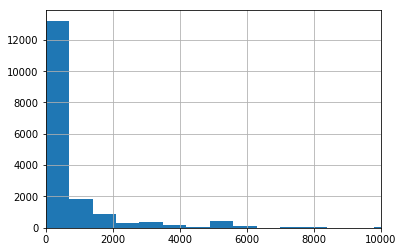

In [81]:
tsh_df.hist(bins = 500)
plt.xlim([0, 10000])

##### 'Total static head' feature is higly skewd(right) with 41693 (70% of records) equal to zero. Hence this has to be imputated using some technique (mean or median).

#### 3. gps_height - Altitude of the well

In [82]:
train_data['gps_height'].isna().sum()

0

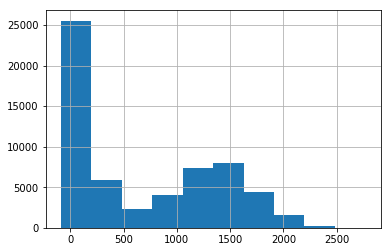

In [83]:
train_data['gps_height'].hist(bins = 10)

##### *** Insight 10 - The "gps height" is also skewed , mening that wells are genrally built at a certain heigh in Tanzania.

#### 4. longitude - GPS coordinate .  This will be delat separately , as it will be used to calculate the distance from the basin.

#### 5. latitude - GPS coordinate. This will be delat separately , as it will be used to calculate the distance from the basin.

#### 6. num_private - The info is completely missing hence nothing can be said or hypothesissed.

#### 7. region_code - Geographic location (coded) -  Locations are important to determine the proximity to the main water bodies , but we will use gps coordinates for the same.

#### 8. district_code - Geographic location (coded) - Locations are important to determine the proximity to the main water bodies , but we will use gps coordinates for the same.

#### 9. population - population - Population around the well 

In [84]:
train_data['population'].isna().sum()

0

(0, 3000)

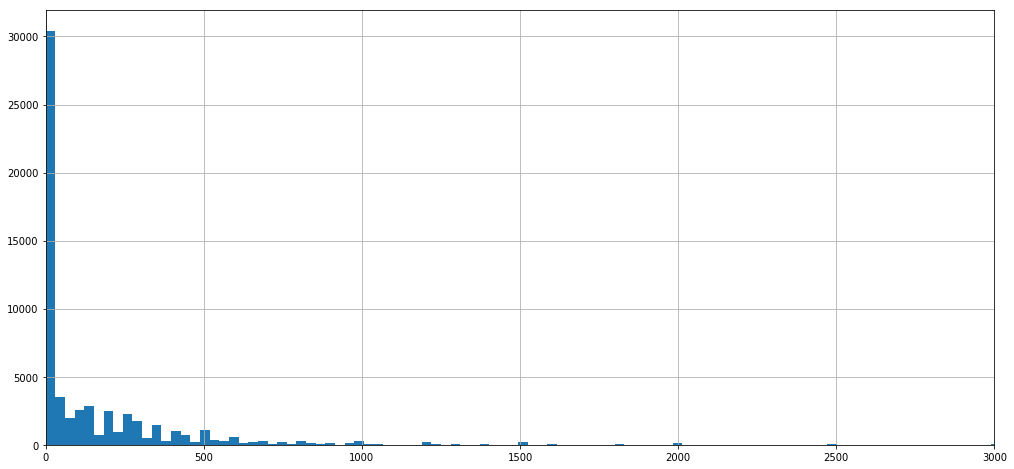

In [85]:
plt.figure(figsize=(17,8))
train_data['population'].hist(bins = 1000)
plt.xlim([0, 3000])


In [86]:
train_data['population'].max()

30500

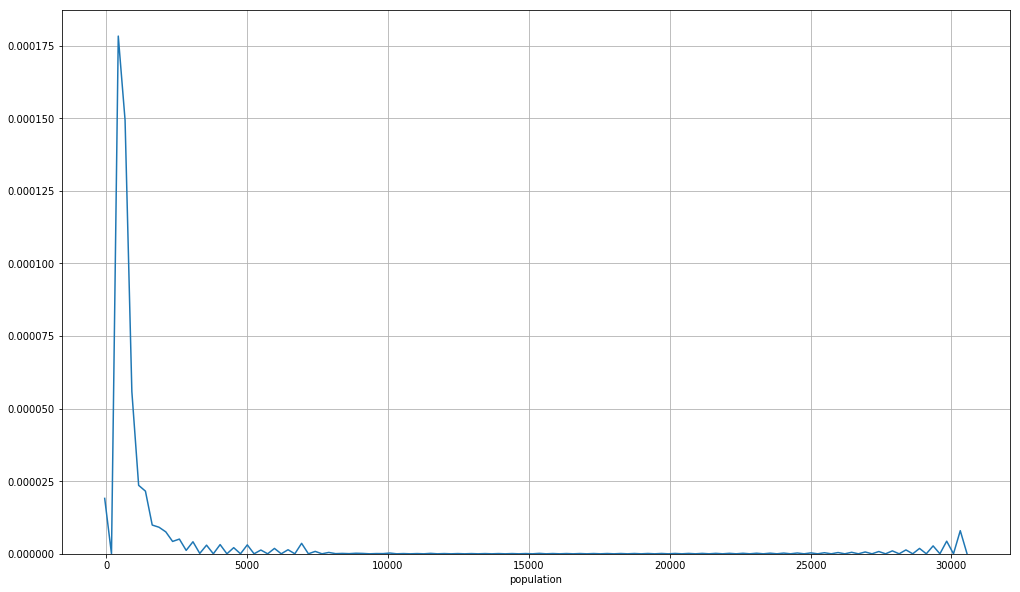

In [87]:
plt.figure(figsize=(17,10))
plt.grid(True)
sns.distplot(train_data['population'] , bins = 500, hist = False)


#### Lets' visualize and analyse the date columns

In [88]:
[col for col in train_data.columns if train_data[col].dtype == 'datetime64[ns]']

['date_recorded']

##### 1. date_recorded - The date the row was entered

In [89]:
train_data['date_recorded'].head()

0   2011-03-14
1   2013-03-06
2   2013-02-25
3   2013-01-28
4   2011-07-13
Name: date_recorded, dtype: datetime64[ns]

In [90]:
year_f = lambda x: x.year

In [91]:
train_data['year_recorded'] = train_data['date_recorded'].apply(year_f)

In [92]:
train_data[['date_recorded','year_recorded']].head()

,date_recorded,year_recorded
0,2011-03-14,2011
1,2013-03-06,2013
2,2013-02-25,2013
3,2013-01-28,2013
4,2011-07-13,2011


In [93]:
year_rcrd = train_data['year_recorded'].astype('str')

In [94]:
year_rcrd = year_rcrd.value_counts()

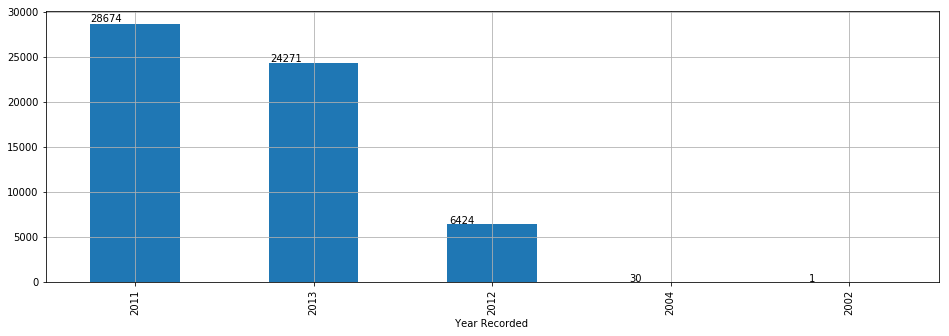

In [95]:
ax = year_rcrd.plot(kind = 'bar' , figsize=(16, 5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Year Recorded ')
plt.grid(True)

In [96]:
train_data['month_recorded'] = train_data['date_recorded'].apply(lambda x: x.month)

In [97]:
train_data[['date_recorded','month_recorded']].head()

,date_recorded,month_recorded
0,2011-03-14,3
1,2013-03-06,3
2,2013-02-25,2
3,2013-01-28,1
4,2011-07-13,7


In [98]:
month_rcrd = train_data['month_recorded'].astype('str')

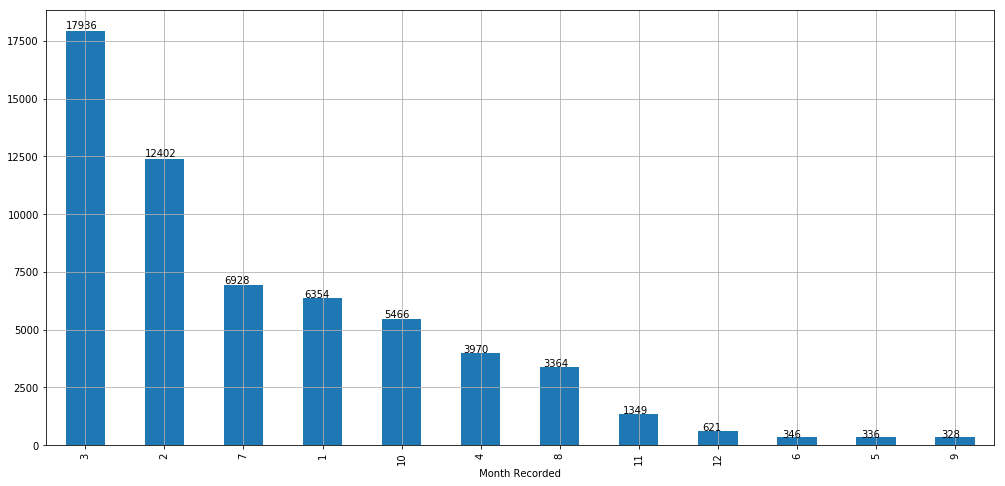

In [99]:
ax = month_rcrd.value_counts().plot(kind = 'bar', figsize=(17, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Month Recorded ')
plt.grid(True)

##### *** Insight 11 - FEB and MARCH are the month where most surveys are conducted followed by july , jan and october. Mid year has very few surveys.  Perhaps , survey should be distributed equally throughout the year , so that status of pumps are noticed before it's too late .

#### 2. construction_year - Year the waterpoint was constructed

In [100]:
train_data['construction_year'].isna().sum()

0

In [101]:
train_data[['date_recorded','construction_year','year_recorded']].head()

,date_recorded,construction_year,year_recorded
0,2011-03-14,1999,2011
1,2013-03-06,2010,2013
2,2013-02-25,2009,2013
3,2013-01-28,1986,2013
4,2011-07-13,0,2011


In [102]:
train_data['years_elapsed'] = train_data['year_recorded'] - train_data['construction_year']

In [103]:
train_data[['date_recorded','construction_year','year_recorded','years_elapsed']].head()

,date_recorded,construction_year,year_recorded,years_elapsed
0,2011-03-14,1999,2011,12
1,2013-03-06,2010,2013,3
2,2013-02-25,2009,2013,4
3,2013-01-28,1986,2013,27
4,2011-07-13,0,2011,2011


In [104]:
len(train_data[train_data['construction_year'] == 0])

20709

###### Since a quite a huge number of records are without the year of construction , the intuition here is to replace/impute this with the mode of the fetaure sans zero.

##### Thus , we can engineer a new feature that gives the life of the pumps.

In [105]:
from scipy.stats import mode
mode(train_data[train_data['construction_year'] != 0]['construction_year'])

ModeResult(mode=array([2010], dtype=int64), count=array([2645]))

##### Mode of the construction_year is 2010

In [106]:
train_data['const_yr_impt_2010'] = np.where(train_data['construction_year'] == 0, 2010, train_data['construction_year'])

In [107]:
train_data['const_yr_impt_2010'].head()

0    1999
1    2010
2    2009
3    1986
4    2010
Name: const_yr_impt_2010, dtype: int64

In [108]:
train_data['years_elapsed'] = train_data['year_recorded'] - train_data['const_yr_impt_2010']

In [109]:
train_data[['date_recorded','construction_year','const_yr_impt_2010','year_recorded','years_elapsed']].head()

,date_recorded,construction_year,const_yr_impt_2010,year_recorded,years_elapsed
0,2011-03-14,1999,1999,2011,12
1,2013-03-06,2010,2010,2013,3
2,2013-02-25,2009,2009,2013,4
3,2013-01-28,1986,1986,2013,27
4,2011-07-13,0,2010,2011,1


In [110]:
train_data.head(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,years_elapsed,const_yr_impt_2010
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,3,12,1999
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2013,3,3,2010
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2013,2,4,2009
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2013,1,27,1986
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2011,7,1,2010
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa,1,True,GeoData Consultants Ltd,VWC,Zingibali,True,2009,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,2011,3,2,2009
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,2012,10,2,2010
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,2012,10,2,2010
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,Lake Tanganyika,Imalauduki,Tabora,14,6,Tabora Urban,Itetemia,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,2012,11,2,2010
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,Lake Victoria,Mkonomre,Kagera,18,1,Karagwe,Kaisho,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft

In [113]:
#### 34.93809275	-9.85632177  
#### Lake Nysa - 11.6701° S, 34.6857° E

In [114]:
train_data['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [115]:
# function to convert degree, minutes , seconds to just to degree .
def conv_degree(lat):
    lat = lat.replace(" ","")
    deg, minutes, seconds, direction =  re.split('[°\'"]', lat)
    return (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

In [116]:
# 'Lake Victoria' = Latitude: -1° 00' 0.00" S Longitude: 33° 00' 0.00" E
lat_1 = conv_degree("""-1° 00' 0.00" S""")
log_1 = conv_degree("""33° 00' 0.00" E""")

# 'Pangani' = Latitude: -5° 25' 30.94" S Longitude: 38° 58' 29.03" E
lat_2 = conv_degree("""-5° 25' 30.94" S""")
log_2 = conv_degree("""38° 58' 29.03" E""")

# 'Rufiji' = Latitude: -8° 00' 0.00" S Longitude: 39° 19' 60.00" E
lat_3 = conv_degree("""-8° 00' 0.00" S""")
log_3 = conv_degree("""39° 19' 60.00" E""")

# 'Internal'(same as ruvu) = Latitude: -6° 48' 17.99" S Longitude: 38° 41' 59.99" E
lat_4 = conv_degree("""-6° 48' 17.99" S""")
log_4 = conv_degree("""38° 41' 59.99" E""")

# 'Lake Tanganyika' = 6.2556° S, 29.5108° E
lat_5 = conv_degree("""6.2556° 0' 00" S""")
log_5 = conv_degree("""29.5108° 0' 00" E""")

# 'Wami / Ruvu' - Latitude: -6° 07' 60.00" S Longitude: 38° 48' 59.99" E
lat_6 = conv_degree("""-6° 07' 60.00" S""")
log_6 = conv_degree("""38° 48' 59.99" E""")

# 'Lake Nyasa' = 11.6701° S, 34.6857° E
lat_7 = conv_degree("""11.6701° 0' 00" S""")
log_7 = conv_degree("""34.6857° 0' 00" E""")

# 'Ruvuma / Southern Coast' = 10.6879° S, 36.2631° E
lat_8 = conv_degree("""10.6879° 0' 00" S""")
log_8 = conv_degree("""36.2631° 0' 00" E""")

#'Lake Rukwa' = 8.0167° S, 32.2654° E
lat_9 = conv_degree("""8.0167° 0' 00" S""")
log_9 = conv_degree("""32.2654° 0' 00" E""")

In [117]:
def get_basin_lat_long(basin , lat_or_long):
    if basin == "Lake Victoria":
        latitude = lat_1
        longitude = log_1
    elif basin == "Pangani":
        latitude = lat_2
        longitude = log_2
    elif basin == "Rufiji":
        latitude = lat_3
        longitude = log_3
    elif basin == "Internal":
        latitude = lat_4
        longitude = log_4
    elif basin == "Lake Tanganyika":
        latitude = lat_5
        longitude = log_5
    elif basin == "Wami / Ruvu":
        latitude = lat_6
        longitude = log_6
    elif basin == "Lake Nyasa":
        latitude = lat_7
        longitude = log_7
    elif basin == "Ruvuma / Southern Coast":
        latitude = lat_8
        longitude = log_8
    elif basin == "Lake Rukwa":
        latitude = lat_9
        longitude = log_9
    
    if lat_or_long.lower() == 'latitude':
        return latitude
    elif lat_or_long.lower() == 'longitude':
        return longitude
        
        

In [118]:
get_basin_lat_long("Lake Tanganyika", 'latitude')

-6.2556

In [119]:
train_data['basin_latitude'] = train_data['basin'].apply(get_basin_lat_long, lat_or_long = 'latitude')

In [120]:
train_data['basin_longitude'] = train_data['basin'].apply(get_basin_lat_long, lat_or_long = 'longitude')

In [127]:
# function to calculate the distance of pumps from the respective basins in KMs
def dist_from_basin(basin_lat, basin_long, pump_lat, pump_long):
    coords_1 = (basin_lat.astype('float64'), basin_long.astype('float64'))
    coords_2 = (pump_lat.astype('float64'), pump_long.astype('float64'))
    
    return geopy.distance.vincenty(coords_1, coords_2).km


In [122]:
dist_list = []
for index, row in train_data[['basin_latitude','basin_longitude','latitude','longitude']].iterrows():
    dist = dist_from_basin(row['basin_latitude'], row['basin_longitude'], row['latitude'], row['longitude'])
    dist_list.append(dist)
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [123]:
len(dist_list)

59400

In [124]:
train_data['basin_pump_dist'] = pd.DataFrame({'basin_pump_dist':dist_list})

In [125]:
train_data[['basin_latitude','basin_longitude','latitude','longitude','basin_pump_dist']].head()

,basin_latitude,basin_longitude,latitude,longitude,basin_pump_dist
0,-11.670100,34.685700,-9.856322,34.938093,202.517704
1,1.000000,33.000000,-2.147466,34.698766,396.072413
2,4.574739,38.974731,-3.821329,37.460664,943.553742
3,-10.687900,36.263100,-11.155298,38.486161,248.454311
4,1.000000,33.000000,-1.825359,31.130847,375.346864


In [126]:
train_data['basin_pump_dist'].isna().sum()

0